# Let's learn how custom environments are built with OpenAI's GYM

## Why am I learning to make environments in gym

I'm following gym's official tutorial for this, I'll try to summarize the stuff here, but this is more of a playground where i just test stuff without worrying about it, its included in the repo anyway becuz it kinda makes sense, im learning it to make the maze environment to test how dynaQ+ learns to beat dynaQ on changing the changing environment... I could do it simply but most of my controls are writen to expect gym Env objects... plus its useful to have some software framework to follow when making environments, afterall in the real world you'll be making your own environments for most of the software based environments...i.e custom games.

# Making Grid World

In [295]:
import gym
from gym import spaces
import pygame
import numpy as np

## The constructor
- Specify Observation space (use the spaces module for observation_space and action space)
- Specify Action space
- Specify Action mappings (int->action) e.g 0->right, 1->up ...
- Manage rendering modes

## Getting Observations
- Return objects that the agent will get upon calling env.reset or env.step
- It can be implemented separately or as a common function like here in _get_obs

## Reset and Step
- Gym really gives you the freedom of doing whatever you want with reset and step as it should
- In reset, reset the states as you wish, in step transform the states as you wish 🙄
- step returns (next_state, reward, done, truncated(optional) , info
- You may have never encountered truncated before like me, but it basically means whether the observation is complete or not... like in rgb observations you may reduce the original observation to be able to manage it becuz its a lot of data... so you'll return truncated to be true, here it is false, because what we observe is what we give to the agent back in form of observation

In [121]:
class GridWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps":4}
    def __init__(self, render_mode=None, size=5):
        self.size = size
        self.window_size = 512 # pygame window size
        
# agent and target locations are encoded within the observation space using spaces.dict (specific to this env)
# the observation space should be defined by spaces... there is no other way
# this is essential and it really is a painless process

        self.observation_space = spaces.Dict({
            "agent": spaces.Box(0, size-1, shape=(2,), dtype=int),
            "target": spaces.Box(0, size-1, shape=(2,), dtype=int)
        })
        
        self.action_space = spaces.Discrete(4)
        self.nS = 2* (size**2)
        self.nA = 4
#         dictionary map (a: (x, y))
        self._action_to_direction = {
            0: np.array([1,0]),
            1: np.array([0,1]),
            2: np.array([-1,0]),
            3: np.array([0,-1]),
        }
        
        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode
        self.window = None
        self.clock = None
    
    def _get_obs(self):
# we need to convert the environment into an observation
# you can write a common method for both reset and step like this or do it separately
        return {"agent": self._agent_location, "target":self._target_location}
    
    def _get_info(self):
#         just as some extra piece of information we can provide manhattan distance
# its really just a distance in terms of boxes/units (DX (boxes difference along X)+ (DY(boxes difference along Y)))
# ord = 1 means its calculating manhattan distance... which is really just sum of the absolutes of the difference in this case

        return {"distance": np.linalg.norm(self._agent_location - self._target_location, ord=1)}
    
    def reset(self, seed = None, options = None):
#         we also need to worry about PRNGs here... gym takes care of that for you.
# allow the function to pass seed and make sure to do super().reset(seed = seed)
#         super().reset()
    
        self._agent_location = np.random.randint(0, self.size, size=(2,), dtype=int)
        self._target_location = self._agent_location
        
        while np.array_equal(self._agent_location, self._target_location):
            self._target_location = np.random.randint(0, self.size, size=(2,), dtype=int)
            
        observation = self._get_obs()
        info = self._get_info()
        
        if self.render_mode == "human":
            self._render_frame()
            
        return observation, info
    
    def step(self, action):
        direction = self._action_to_direction[action]
        
        self._agent_location = np.clip(
        self._agent_location + direction, 0, self.size-1)
        
        terminated = np.array_equal(self._agent_location, self._target_location)
        
#         rewards are sparse (u get 1 when u reach target else u get 0), its called binary sparse rewards lol

        reward = 1 if terminated else 0
        observation = self._get_obs()
        info = self._get_info()
        
        if self.render_mode == "human":
            self._render_frame()
        
        return observation, reward, terminated,False, info
    
    def render(self):
        if self.render_mode =="rgb_array":
            return self._render_frame()
    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # First we draw the target
        pygame.draw.rect(
            canvas,
            (255, 0, 0),
            pygame.Rect(
                pix_square_size * self._target_location,
                (pix_square_size, pix_square_size),
            ),
        )
        # Now we draw the agent
        pygame.draw.circle(
            canvas,
            (0, 0, 255),
            (self._agent_location + 0.5) * pix_square_size,
            pix_square_size / 3,
        )

        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )


In [117]:
env = GridWorldEnv()

In [250]:
def initializer(nS, nA):
#     0,0,0,0 -> 4,4,4,4
    indices = np.indices((5,5,5,5))
    keys = np.stack(indices, axis=-1).reshape((-1,4))
    Q = {tuple(key): np.random.normal(0.5, 0.25, (nA,)) for key in keys}
    
    return Q

In [442]:
class QControl:
    def __init__(self, nS, nA, terminal=list(range(37,48)), eps=None, initializer=None):
        self.Q = np.random.normal(0.5,0.25, (nS, nA) )

        
        if initializer!=None:
            self.Q = initializer(nS, nA)
        
        
        for i in terminal:
            self.Q[i] = np.array([0, 0, 0, 0])
        
        self.pi = np.random.randint(0, 4, (16, ), dtype=np.int8)
        self.alpha = 0.2
        self.gamma = 0.9
        self.epsilon = eps
        self.last_action = 0
    
    def policy(self, state, eps=None):
        
        if eps == None:
            if self.epsilon != None:
                eps = self.epsilon
            else:
                eps = 0.2
        
        
        if np.random.random() >= eps:
            return np.argmax(self.Q[state])
        else:
            return np.random.randint(0, 4)
        
    def learn(self, s, env, step_size, eps=None):
        if eps == None:
            if self.epsilon != None:
                eps = self.epsilon
            else:
                eps = 0.2
        a = self.policy(s, eps=eps)
        s_, r, done, _, info = env.step(a)
        
        s_ = tuple([*s_["agent"], *s_["target"] ])
        self.Q[s][a] = self.Q[s][a] + step_size*(r + np.max(self.Q[s_]) - self.Q[s][a]   )
        
        self.last_action = a
        
        return s_, r, done,_, info
    
    def plan(self, s, model, step_size,a,  eps=None):
        
                
        r, s_ = model[(s,a)]
        self.Q[s][a] = self.Q[s][a] + step_size*(r + np.max(self.Q[s_]) - self.Q[s][a]   )
        self.last_action = a
        return s_, r, False, {}
    
    def load_q_values(self, file_location):
        f = open(file_location, "rb")
        self.Q = pickle.load(f)

In [461]:
def dyna(QControl, env, planning_steps, n_episodes,  step_size=0.5, episode_limit = 500):
    
    q_control = QControl(env.nS, env.nA, eps=0.2, terminal=[], initializer=initializer)
    model = {}
    
    observed_states = set({})
    
    indices = np.indices((5,5,5,5))
    keys = np.stack(indices, axis=-1).reshape((-1,4))
    
    observed_actions = {tuple(key):set() for key in keys}
    curr_s = env.reset()
    rewards = []
    Rs= 0
    steps = []
    for i in range(n_episodes):
        if i%100 == 0:
            print("{:.2f} % done".format(i/n_episodes))
        done = False
        Rs = 0
        steps_this_episode = 0
        curr_s = env.reset()
        curr_s = tuple([*curr_s[0]["agent"], *curr_s[0]["target"] ])
        while not done and steps_this_episode < episode_limit:
        
            s_, r, done, _,info = q_control.learn(curr_s, env, step_size)
            a = q_control.last_action
            
            model[curr_s, a] = [r, s_]


            observed_actions[curr_s].add(a)
            observed_states.add(curr_s)
            curr_s = s_
            Rs+=r
            steps_this_episode += 1
                



            for n in range(planning_steps):
                states = list(observed_states)
                
                s = np.random.choice(np.arange(len(states)))
                actions = list(observed_actions[states[s]])
                
                a = np.random.choice(actions)
                

                
                
                q_control.plan(states[s], model, step_size, a)

        rewards.append(Rs)
        steps.append(steps_this_episode)
    return rewards, steps, q_control
    

In [462]:
rs0, steps0, qcontrol = dyna(QControl, env, 30, 2000, step_size=0.01, episode_limit=1000)

0.00 % done
0.05 % done
0.10 % done
0.15 % done
0.20 % done
0.25 % done
0.30 % done
0.35 % done
0.40 % done
0.45 % done
0.50 % done
0.55 % done
0.60 % done
0.65 % done
0.70 % done
0.75 % done
0.80 % done
0.85 % done
0.90 % done
0.95 % done


In [463]:
import matplotlib.pyplot as plt

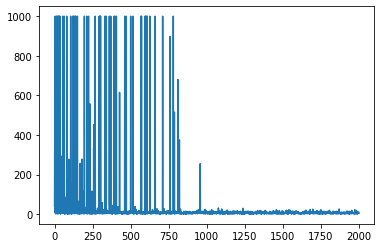

In [464]:
plt.plot(steps0)

In [351]:

model ={((4, 0, 4, 2), 0): [0, (4, 0, 4, 2)]}


In [352]:
model[((4, 0, 4, 2), 0)]

[0, (4, 0, 4, 2)]

In [383]:
s = env.reset()

In [397]:
def demo_policy(control, limit=30):
    env.reset()
#     out = env.render(mode="ansi")
    done = False
    s = env.reset()
    s = tuple([*s[0]["agent"], *s[0]["target"] ])
    i = 0
    while not done:
        
        s_, r, done, prop, _ = env.step(np.argmax(control.Q[s]))
        
        env.render()
        s_ = tuple([*s_["agent"], *s_["target"] ])
        s = s_
        i+=1
        if done:
            print("congrats")
        if i >= limit:
            done = True
            

In [456]:
control = QControl(env.nS, env.nA, eps=0.2, terminal=[], initializer=initializer)
control.load_q_values("Q_Values_Grid_World.pkl")

In [460]:
demo_policy(control)

congrats


In [436]:
import pickle

In [439]:
def save_q_values(Q):
    with open("Q_Values_Grid_World.pkl", "wb") as f:
        pickle.dump(Q, f)
    
        
    

In [465]:
save_q_values(qcontrol.Q)

In [466]:
!explorer .
